# Sound & velocity

*Imports and data_folder access*

In [1]:
import pickle
import numpy as np
from pathlib import Path
import glob
import pandas as pd
import matplotlib.pyplot as plt

# switch the path to represent the correct directory when switching devices and fetch the latest repo from github
# Marc_PC
data_folder_1 = Path(r"C:\Users\marc_\OneDrive\Documents\Studie\Master\Master Internship 1 Neurophysics\Project-collective-cortical-dynamics-with-non-linear-dimensionality-reduction\data")
data_folder_2 = Path(r"Z:\davide\2p_data\441394_ribolla")
data_folder_3 = Path(r"Z:\davide\2p_data\441406_fiano")

# Amber_laptop
#data_folder_1 = Path(r"C:\Users\renek\OneDrive\Documenten\Marc Studiemap\Master Internship 1\Project-collective-cortical-dynamics-with-non-linear-dimensionality-reduction\data")
#data_folder_2 = Path(r"Z:\davide\2p_data\441394_ribolla")
#data_folder_3 = Path(r"Z:\davide\2p_data\441406_fiano")

In [2]:
# Path to where the data is on your machine.
data_path_1 = data_folder_1.joinpath('20230211')

# ribolla files
data_path_2 = data_folder_2.joinpath('20230315')
data_path_3 = data_folder_2.joinpath('20230324')
data_path_4 = data_folder_2.joinpath('20230331')
data_path_5 = data_folder_2.joinpath('20230404')
data_path_6 = data_folder_2.joinpath('20230405')

# fiano files
data_path_7 = data_folder_3.joinpath('20230309')
data_path_8 = data_folder_3.joinpath('20230317')
data_path_9 = data_folder_3.joinpath('20230323')
data_path_10 = data_folder_3.joinpath('20230328')
data_path_11 = data_folder_3.joinpath('20230331')

# Create a list to store all the data paths
all_data_paths = [
    data_path_1,
    data_path_2,
    data_path_3,
    data_path_4,
    data_path_5,
    data_path_6,
    data_path_7,
    data_path_8,
    data_path_9,
    data_path_10,
    data_path_11
]

In [3]:
import sys
sys.path.append('../src') # Add src folder to path.
import file_management as fm # Import my file_management functions from /src.

selected_data_session = all_data_paths[1] # select one of the sessions! 0-10
fm.get_files_in_data_path(selected_data_session)

['Z:\\davide\\2p_data\\441394_ribolla\\20230315\\behaviour_data.pickle',
 'Z:\\davide\\2p_data\\441394_ribolla\\20230315\\cnmf.hdf5',
 'Z:\\davide\\2p_data\\441394_ribolla\\20230315\\decoded_log.mat',
 'Z:\\davide\\2p_data\\441394_ribolla\\20230315\\metrics.pickle',
 'Z:\\davide\\2p_data\\441394_ribolla\\20230315\\neural_data.pickle',
 'Z:\\davide\\2p_data\\441394_ribolla\\20230315\\parameters.yml',
 'Z:\\davide\\2p_data\\441394_ribolla\\20230315\\tif_header.pickle',
 'Z:\\davide\\2p_data\\441394_ribolla\\20230315\\trial_data.csv']

In [4]:
selected_data_session

WindowsPath('Z:/davide/2p_data/441394_ribolla/20230315')

In [5]:
import os

# List all the files in the selected data session
files = os.listdir(selected_data_session)
print(files)

['behaviour_data.pickle', 'cnmf.hdf5', 'decoded_log.mat', 'metrics.pickle', 'neural_data.pickle', 'parameters.yml', 'tif_header.pickle', 'trial_data.csv']


In [6]:
import sys
sys.path.append('../src') # Add src folder to path.

import sound_velocity_analysis as sva # Import my sound velocity analysis functions from /src.
import histogram_analysis as ha # Import my histogram analysis functions from /src.

*Multi-Session*

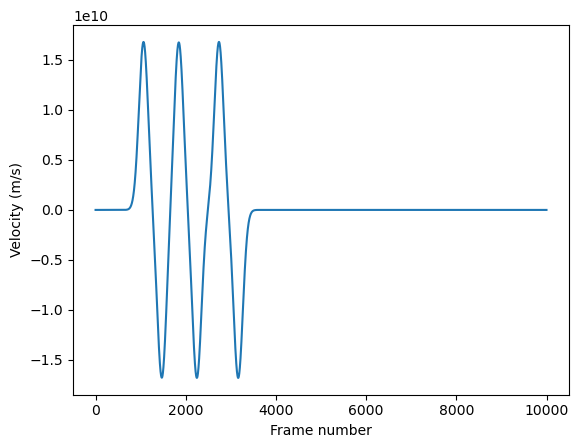

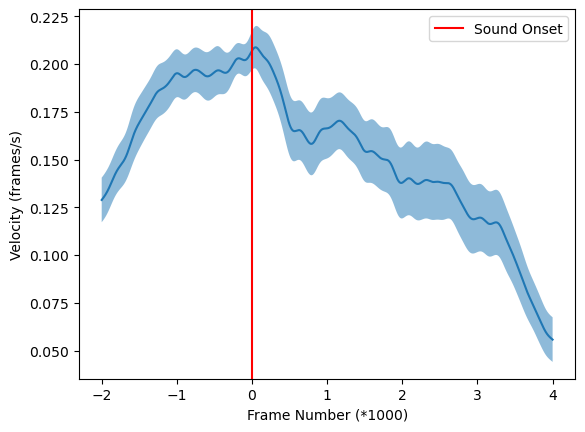

The difference between the speed distributions before and after the sound onset is statistically significant (p < 0.0500)


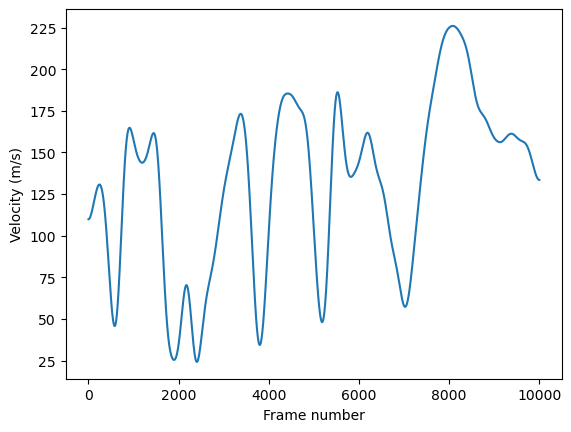

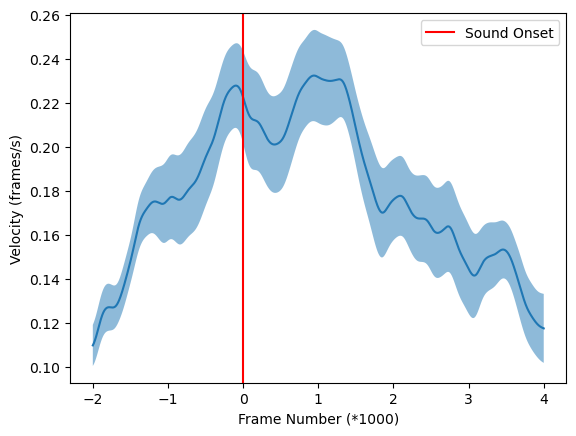

The difference between the speed distributions before and after the sound onset is statistically significant (p < 0.0500)


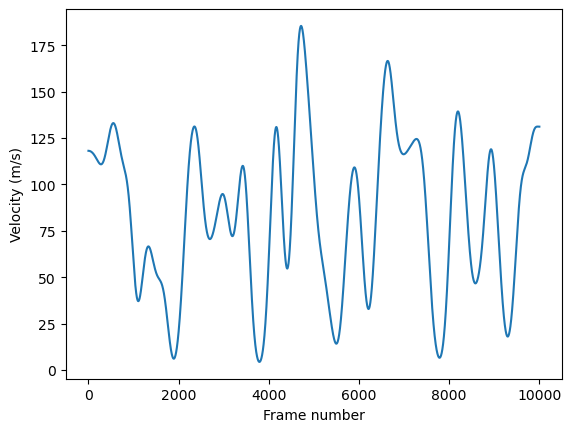

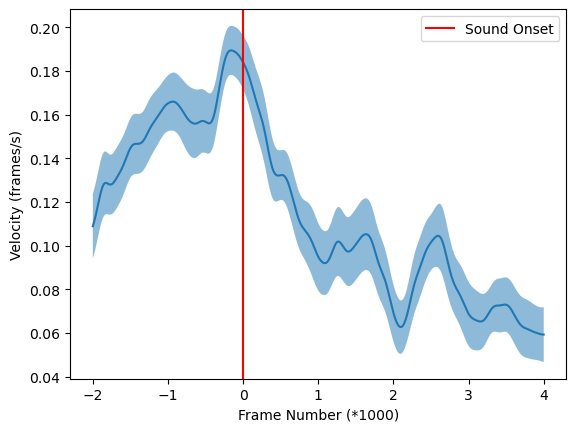

The difference between the speed distributions before and after the sound onset is statistically significant (p < 0.0500)


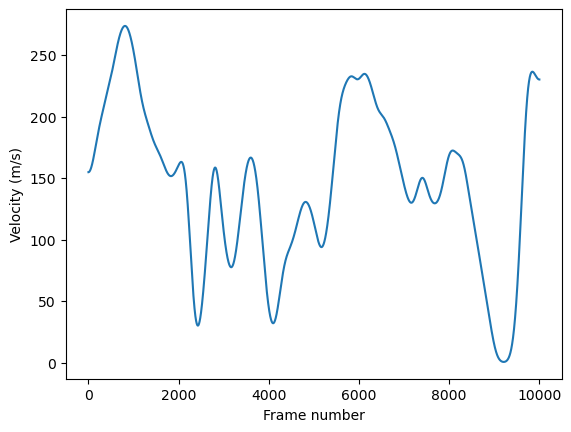

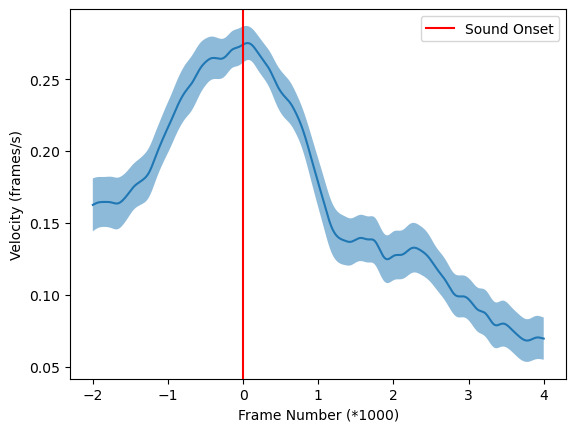

The difference between the speed distributions before and after the sound onset is statistically significant (p < 0.0500)


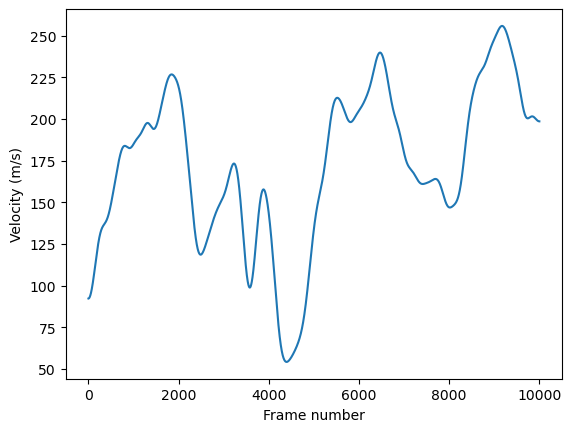

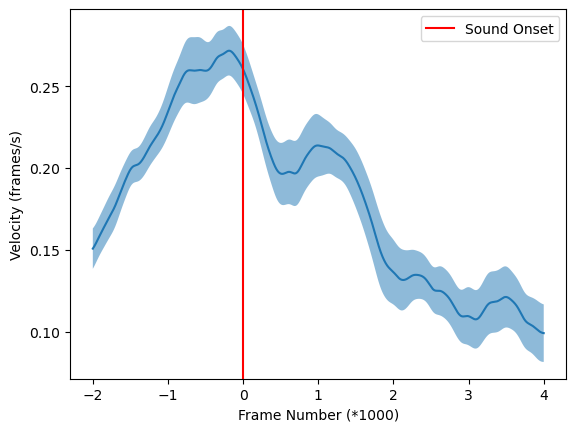

The difference between the speed distributions before and after the sound onset is statistically significant (p < 0.0500)


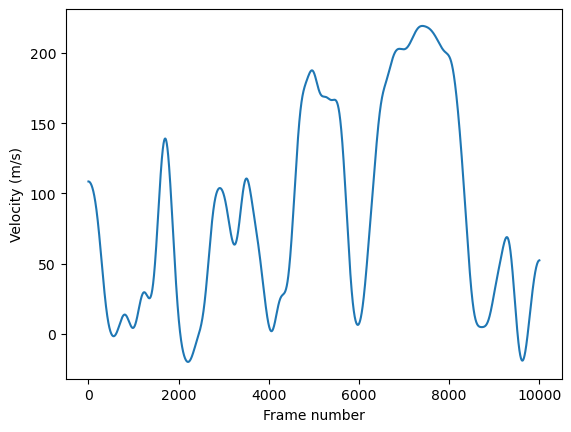

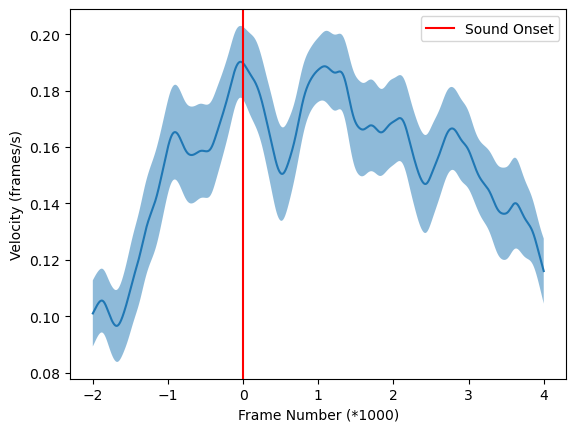

The difference between the speed distributions before and after the sound onset is statistically significant (p < 0.0500)


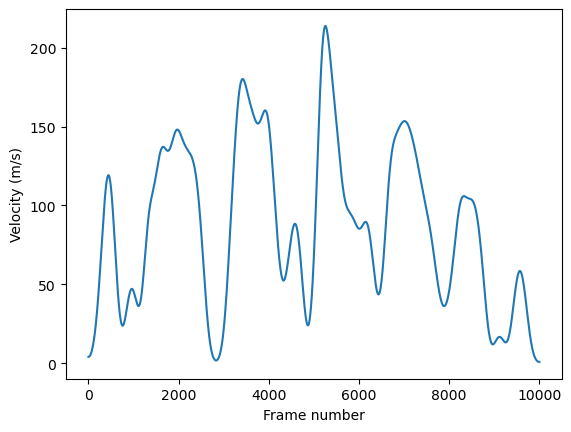

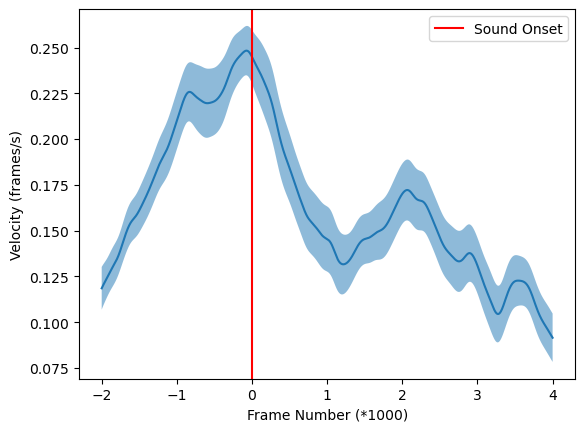

The difference between the speed distributions before and after the sound onset is statistically significant (p < 0.0500)


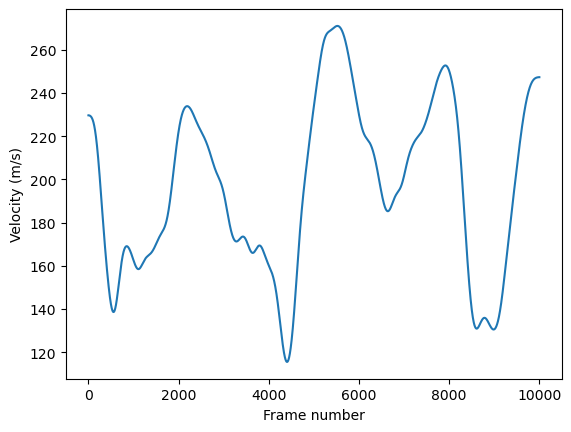

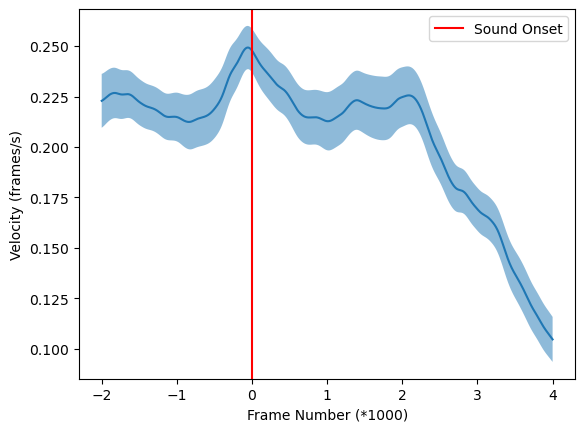

The difference between the speed distributions before and after the sound onset is statistically significant (p < 0.0500)


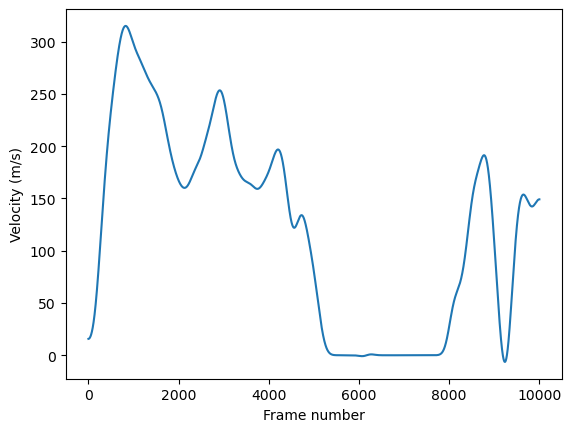

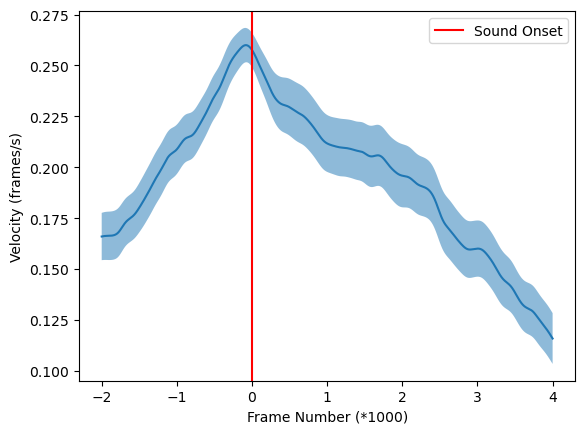

The difference between the speed distributions before and after the sound onset is statistically significant (p < 0.0500)


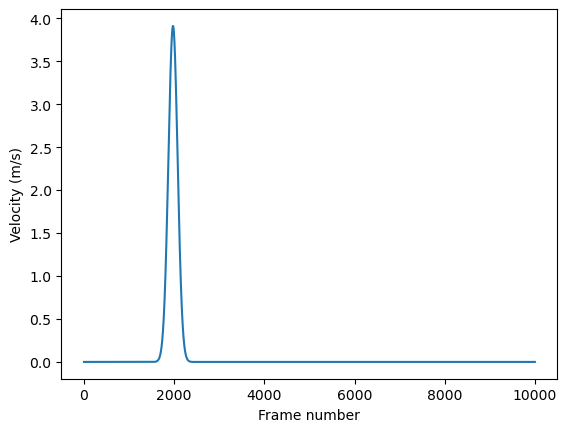

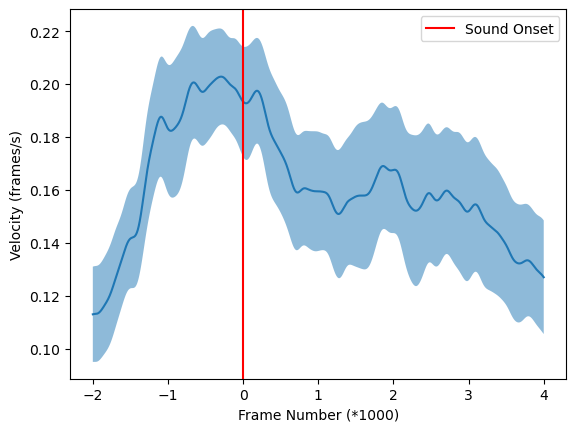

The difference between the speed distributions before and after the sound onset is statistically significant (p < 0.0500)


In [7]:
# Create an empty dataframe to store the velocity results
velocity_df = pd.DataFrame(columns=['Session', 'Average Velocity', 'Standard Deviation', 'Standard Error'])
# Create an empty dataframe to store the t-test results
ttest_df = pd.DataFrame(columns=['Session', 't-statistic', 'p-value'])

for session in all_data_paths[1:]:
    
    trial_data_file = session.joinpath('trial_data.csv')
    trial_data = pd.read_csv(trial_data_file)

    bdata_file = session.joinpath('behaviour_data.pickle')
    with open(bdata_file,'rb') as file:
        b_data = pickle.load(file)

    position = b_data['position']
    pos_list = []
    for i in range(len(trial_data)):
        row = trial_data.iloc[i]
        onset = row['env_onset'].astype(int)
        offset = row['tunnel2_offset']

        pos_segment = position[onset:offset]
        #print(f'{i}: {np.max(pos_segment)-np.min(pos_segment)}')
        # normalize
        pos_segment = (pos_segment - np.min(pos_segment))/(np.max(pos_segment)-np.min(pos_segment))
        pos_list.append(pos_segment)
        position = b_data['position']
        rz_onsets = []
        tunnel1_onsets = []

    for i in range(len(trial_data)):
        row = trial_data.iloc[i]
        onset = row['env_onset'].astype(int)
        offset = row['tunnel2_offset']

        pos_segment = position[onset:offset]
        min_pos = np.min(pos_segment)
        max_pos = np.max(pos_segment)

        rz_pos = ha.compute_feature_position(row['reward_zone_onset'],position,min_pos,max_pos)
        rz_onsets.append(rz_pos)

        t1_pos = ha.compute_feature_position(row['tunnel1_onset'],position,min_pos,max_pos)
        tunnel1_onsets.append(t1_pos)
        
        #normalize
        pos_segment = (pos_segment - np.min(pos_segment))/(np.max(pos_segment)-np.min(pos_segment))

        if i==0:
            norm_pos = pos_segment
        else:
            norm_pos = np.hstack([norm_pos,pos_segment])
    
    from scipy.ndimage import gaussian_filter1d
    dt = 1./1000. # Frequency of the recording apparatus is 1000 Hz.
    pos = gaussian_filter1d(b_data['position'].astype(float),sigma=2) # Can vary with sigma value for additional smoothing.
    vel = np.diff(pos.astype(float)) # Calculate the n-th discrete difference along the given axis.
    vel = gaussian_filter1d(vel,50)

    vel_data = sva.compute_velocity(b_data, pos_sigma=2, vel_sigma=20, vel_win=10000, vel_smooth=100)
    vel = vel[:len(norm_pos)]
    from scipy.stats import binned_statistic # Import a function from a library module.
    
    nbins=50 # Number of bins.
    avg_vel,edges,_ = binned_statistic(norm_pos,vel,bins=nbins) # Use _ (underscore) to have a function return a value in an unused character to avoid error.
    centers = [(edges[i+1]+edges[i])/2 for i in range(len(edges)-1)] # The centers represent the midpoint of each bin. The edges represent the boundaries of each bin.

    # Define compute start & end.
    t_on = 2000
    t_off = 4000

    # Initialize the velocity matrix and count variable.
    vel_matrix = np.zeros((len(trial_data), t_on + t_off))
    count = 0

    # Cycle over the trials using integer indexing.
    for i in range(len(trial_data)):
        
        # Get the current trial row.
        row = trial_data.iloc[i] 

        # The timecourse of interest for the velocity.
        if not np.isnan(row['sound_onset']):
            onset = row['sound_onset'].astype(int) - t_on # 2 seconds before.
            offset = row['sound_onset'].astype(int) + t_off # 2 seconds after.
            trial_vel = vel[onset:offset]
            #print(len(trial_vel))
            if i == 0: # Compared to hstack, vstack requires slices of equal length.
                vel_matrix = trial_vel
            else:
                vel_matrix = np.vstack([vel_matrix,trial_vel])

    vel_matrix = sva.computed_sliced_matrix(trial_data, vel, 2000, 4000)

    save_folder = Path('./imgs/average_velocity_plots')
    save_folder.mkdir(exist_ok=True,parents=True)
    avg_vel, std_vel, sem_vel = sva.avg_std_sem_velocity(vel_matrix, t_on, t_off, session, save_folder)

    # Create a temporary dataframe for the velocity results of the current session
    session_vel_df = pd.DataFrame({
        'Session': [str(session)],
        'Average Velocity': [avg_vel],
        'Standard Deviation': [std_vel],
        'Standard Error': [sem_vel]
    })
    
    # Append the temporary velocity dataframe to the velocity dataframe
    velocity_df = pd.concat([velocity_df, session_vel_df], ignore_index=True)

    t_stat, p_val = sva.ttest_speed_distribution(vel_matrix, 2000)

    # Create a temporary dataframe for the t-test results of the current session
    session_ttest_df = pd.DataFrame({
        'Session': [str(session)],
        't-statistic': [t_stat],
        'p-value': [p_val]
    })

    # Append the temporary t-test dataframe to the t-test dataframe
    ttest_df = pd.concat([ttest_df, session_ttest_df], ignore_index=True)


In [8]:
# Specify the desired path and filename for vel_df
vel_df_output_path = Path('../data/final/velocity_stats.csv')

# Save the velocity dataframe to a CSV file
velocity_df.to_csv(vel_df_output_path, index=False)

# Specify the desired path and filename for ttest_df
ttest_df_output_path = Path('../data/final/vel_ttest_stats.csv')

# Save the t-test dataframe to a CSV file
ttest_df.to_csv(ttest_df_output_path, index=False)